# Turbofan Engine - Data set: FD001
## RUL definitions

In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import myFunctions as f

In [2]:
train, test, RUL = f.import_("train_FD001.txt", "test_FD001.txt", "RUL_FD001.txt")

In [3]:
train = f.drop_cols(train)
train.head()

,unit_number,n_cycles,sm_2,sm_3,sm_4,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_14,sm_15,sm_17,sm_20,sm_21
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


### 1.Linear RUL 
Assumption: RUL decreases linearly over time and have a value of 0 at the last time cycle of the engine. 

In [4]:
def get_index(unit, cycle, S):
    """get the index of a row, based on the unit number and the cycle"""
    
    s1 = set(S.index[S['unit_number'] == unit].tolist())
    s2 = set(S.index[S['n_cycles'] == cycle].tolist())
    return list(s1 & s2)[0]

In [5]:
def linearRUL(train):
    """function that takes as an input the train set
    the output is the dataset with an extra column: RUL, caculated as the number of cycles before failure"""
    
    # create an empty column 
    trainLR = train.assign(linear_RUL = " ")
    cols = trainLR.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    trainLR = trainLR[cols]
    
    for unit in trainLR["unit_number"].unique():
        #last cycle
        maxcycle = max(trainLR[trainLR["unit_number"] == unit]["n_cycles"])

        # initial values
        idx = get_index(unit, maxcycle, trainLR)
        cycle = maxcycle
        value = 0

        # place a 0 on the last day (failure)
        trainLR.loc[idx, 'linear_RUL'] = int(value)

        while value < (maxcycle - 1):
            cycle -= 1
            value += 1
            idx = get_index(unit, cycle, trainLR)
            trainLR.loc[idx, 'linear_RUL'] = int(value)
        
    return trainLR

In [6]:
trainLR = linearRUL(train)
trainLR.head()

,linear_RUL,unit_number,n_cycles,sm_2,sm_3,sm_4,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_14,sm_15,sm_17,sm_20,sm_21
0,191,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,190,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,189,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,188,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,187,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


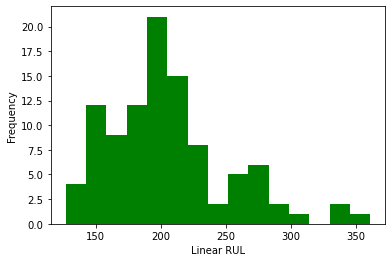

In [7]:
plt.hist(trainLR.groupby("unit_number").max()["linear_RUL"].values, color = "g", bins = 15)
plt.xlabel('Linear RUL')
plt.ylabel('Frequency')
plt.show()

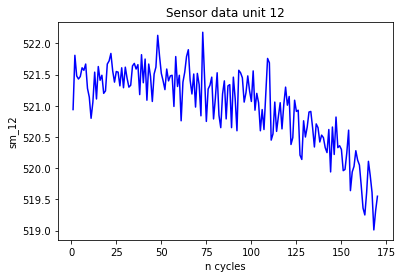

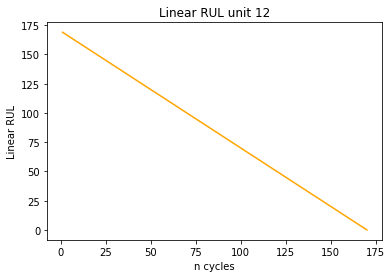

In [8]:
units = trainLR["unit_number"].unique()
unit = random.choice(units)
sm = "sm_12" # choose the atribute with max feature importance

rul = trainLR[trainLR["unit_number"]==unit]["linear_RUL"].values
s = trainLR[trainLR["unit_number"]==unit][sm].values
x = trainLR[trainLR["unit_number"]==unit]["n_cycles"].values

plt.plot(x, s, color = "blue")
plt.xlabel("n cycles")
plt.ylabel(sm)
plt.title("Sensor data unit "+str(unit))
plt.show()

plt.plot(x, rul, color = "orange")
plt.xlabel("n cycles")
plt.ylabel("Linear RUL")
plt.title("Linear RUL unit "+str(unit))
plt.show()

### 2. Clipped RUL
Assumption: the RUL starts to decline after a threshold

In [10]:
def clipRUL(train, t):
    # create dataset with linear RUL
    trainLR = linearRUL(train)
    units = train["unit_number"].unique()
    all_clip_rul = []
    for unit in units:
        clip_rul = trainLR[trainLR["unit_number"]==unit]["linear_RUL"].clip(upper = t).values
        all_clip_rul.append(clip_rul)
    all_clip_rul = np.concatenate(all_clip_rul)
    
    trainC = trainLR[trainLR.columns[1::]]
    trainC.insert(0, "clip_RUL", all_clip_rul)
    return trainC

In [11]:
trainC = clipRUL(train, 125)
trainC.head()

,clip_RUL,unit_number,n_cycles,sm_2,sm_3,sm_4,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_14,sm_15,sm_17,sm_20,sm_21
0,125,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,125,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,125,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,125,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,125,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


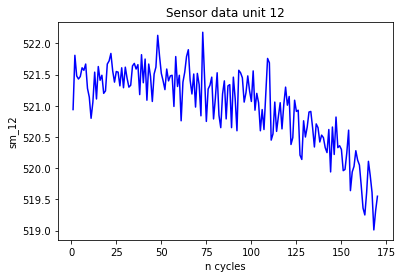

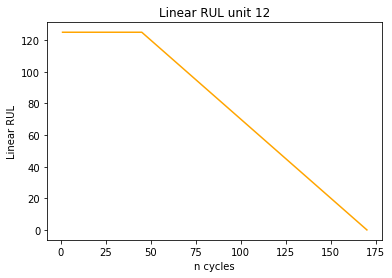

In [16]:
rul = trainC[trainC["unit_number"]==unit]["clip_RUL"].values
s = trainC[trainC["unit_number"]==unit][sm].values
x = trainC[trainC["unit_number"]==unit]["n_cycles"].values

plt.plot(x, s, color = "blue")
plt.xlabel("n cycles")
plt.ylabel(sm)
plt.title("Sensor data unit "+str(unit))
plt.show()

plt.plot(x, rul, color = "orange")
plt.xlabel("n cycles")
plt.ylabel("Linear RUL")
plt.title("Linear RUL unit "+str(unit))
plt.show()

### 3. Detection of the starting point of the degradation process